In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/researchtopictags/test.csv
/kaggle/input/researchtopictags/train.csv
/kaggle/input/researchtopictags/sample.csv


In [2]:
!pip install -q transformers==2.11.0
!wget https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/tensorflow_models/scibert_scivocab_uncased.tar.gz
!tar -xvf ./scibert_scivocab_uncased.tar.gz

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
--2020-08-25 04:33:27--  https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/tensorflow_models/scibert_scivocab_uncased.tar.gz
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.200.40
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.200.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216161420 (1.1G) [application/x-tar]
Saving to: ‘scibert_scivocab_uncased.tar.gz’

scibert_scivocab_un 100%[===================>]   1.13G  48.0MB/s    in 28s     

2020-08-25 04:33:55 (41.0 MB/s) - ‘scibert_scivocab_uncased.tar.gz’ saved [1216161420/1216161420]

scibert_scivocab_uncased/
scibert_scivocab_uncased/bert_model.ckpt.data-00000-of-00001
scibert_scivocab_uncased/bert_model.ckpt.index
scibert_scivocab_uncased/vocab.txt
scibert_scivocab_uncased/bert_model.ckpt.meta
scibert_scivocab_uncased/bert_config.json


In [3]:
os.environ["WANDB_API_KEY"] = "0" ## to silence warning
!transformers-cli convert --model_type bert \
  --tf_checkpoint './scibert_scivocab_uncased/bert_model.ckpt' \
  --config './scibert_scivocab_uncased/bert_config.json' \
  --pytorch_dump_output './scibert_scivocab_uncased/pytorch_model.bin'

Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 31090
}

Save PyTorch model to ./scibert_scivocab_uncased/pytorch_model.bin


In [4]:
from tqdm.notebook import tqdm,tnrange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
import seaborn as sns
import tensorflow as tf

from transformers import BertTokenizer ,BertConfig
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import TFBertModel
from tensorflow.keras.layers import Dense, Flatten,Dropout

import time
from transformers import create_optimizer
from tensorflow.keras.callbacks import LearningRateScheduler , EarlyStopping

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
train_data = pd.read_csv('/kaggle/input/researchtopictags/train.csv')
print(train_data.shape)
train_data.head()

(20972, 9)


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [7]:
test_data = pd.read_csv('/kaggle/input/researchtopictags/test.csv')
print(test_data.shape)
test_data.head()

(8989, 3)


,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [8]:
train_data['combined_text'] = train_data['TITLE'] + " <join> " + train_data['ABSTRACT']
test_data['combined_text'] = test_data['TITLE'] + " <join> " + test_data['ABSTRACT']

In [9]:
label_cols = ['Computer Science','Physics','Mathematics', 'Statistics','Quantitative Biology','Quantitative Finance']

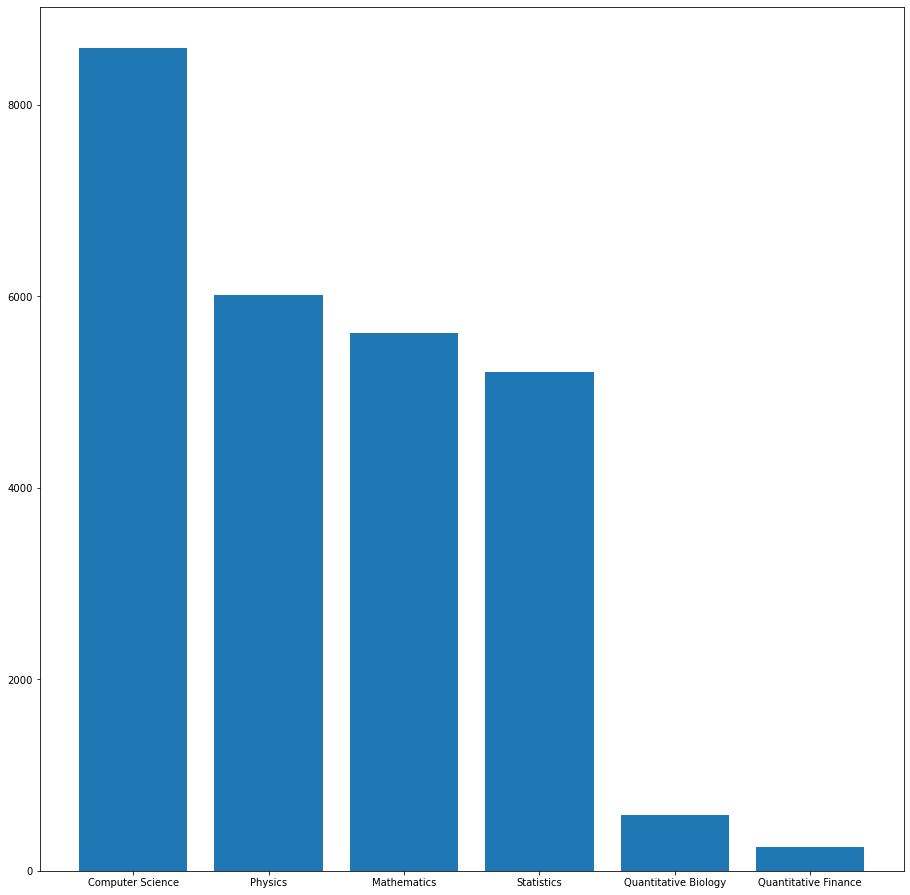

In [10]:
com_sc = train_data['Computer Science'].value_counts()[1]
phy = train_data['Physics'].value_counts()[1]
mat = train_data['Mathematics'].value_counts()[1]
stats = train_data['Statistics'].value_counts()[1]
bio = train_data['Quantitative Biology'].value_counts()[1]
fin = train_data['Quantitative Finance'].value_counts()[1]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
counts = [com_sc,phy,mat,stats,bio,fin]
ax.bar(label_cols,counts)
plt.show()

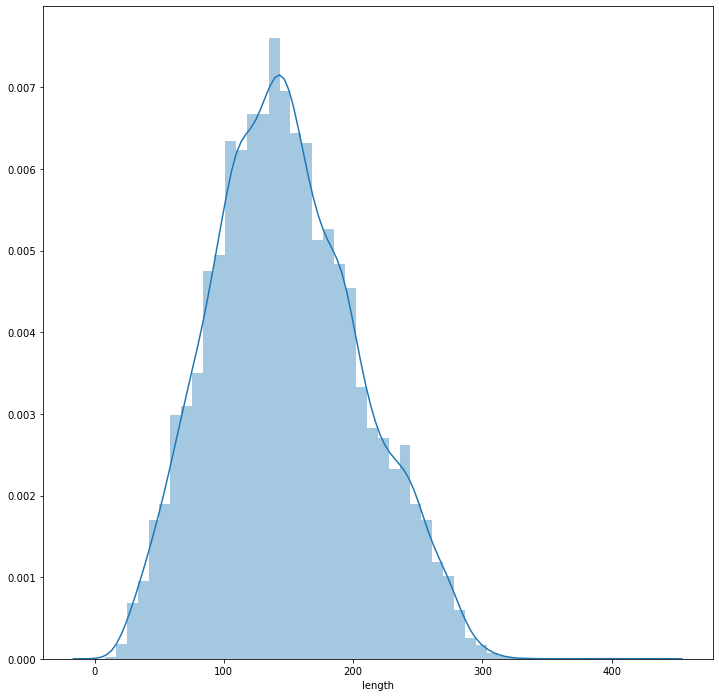

In [11]:
train_data['length'] = train_data['combined_text'].apply(lambda x : x.count(" ") + 1)
sns.distplot(train_data['length'])

In [12]:
# Parameters

BATCH_SIZE = 16 * strategy.num_replicas_in_sync

TEST_BATCH_SIZE = 16 * strategy.num_replicas_in_sync

NR_EPOCHS = 2

MAX_LEN = 300

bert_model_name = './scibert_scivocab_uncased'

config = BertConfig.from_json_file('./scibert_scivocab_uncased/bert_config.json')

In [13]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

def tokenize_sentences(sentences, tokenizer, max_seq_len = 128):
    
    tokenized_sentences = []

    for sentence in tqdm(sentences):
        
        tokenized_sentence = tokenizer.encode(sentence,                  
                                              add_special_tokens = True, 
                                              max_length = max_seq_len  
                                             )
        
        tokenized_sentences.append(tokenized_sentence)

    return tokenized_sentences

def create_attention_masks(tokenized_and_padded_sentences):
    
    attention_masks = []

    for sentence in tokenized_and_padded_sentences:
        
        att_mask = [int(token_id > 0) for token_id in sentence]
        
        attention_masks.append(att_mask)

    return np.asarray(attention_masks)

input_ids = tokenize_sentences(train_data['combined_text'], tokenizer, MAX_LEN)

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")

attention_masks = create_attention_masks(input_ids)

In [14]:
class BertClassifier(tf.keras.Model):    
    
    def __init__(self, bert: TFBertModel, num_classes: int):
        
        super().__init__()
        
        self.bert = bert
        
        self.classifier = Dense(num_classes, activation='sigmoid')
        
    def call(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None):
        
        outputs = self.bert(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
        
        cls_output = outputs[1]
        
        cls_output = self.classifier(cls_output)
                
        return cls_output

In [15]:
def create_dataset(data_tuple, batch_size, train=True):
    
    dataset = tf.data.Dataset.from_tensor_slices(data_tuple)
    
    if train:
        
        dataset = dataset.repeat(NR_EPOCHS)
        
        dataset = dataset.shuffle(buffer_size=10000)
    
    else:
        
        dataset = dataset.repeat(1)
    
    dataset = dataset.batch(batch_size)
    
    if train:
        
        dataset = dataset.prefetch(1)
        
    if not train:
        
        dataset = dataset.cache()
    
    return dataset


labels =  train_data[label_cols].values

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=0, test_size=0.3)

train_masks, validation_masks = train_test_split(attention_masks, random_state=0, test_size=0.3)

train_size = len(train_inputs)

validation_size = len(validation_inputs)

train_dataset = create_dataset(((train_inputs, train_masks), train_labels), batch_size=BATCH_SIZE,train=True)

validation_dataset = create_dataset(((validation_inputs, validation_masks), validation_labels), batch_size=BATCH_SIZE,train=False)

In [16]:
def create_test_dataset():
    
    test_input_ids = tokenize_sentences(test_data['combined_text'], tokenizer, MAX_LEN)
    
    test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    
    test_attention_masks = create_attention_masks(test_input_ids)
    
    test_steps = len(test_data) // TEST_BATCH_SIZE
    
    test_dataset = create_dataset(((test_input_ids, test_attention_masks),), batch_size=TEST_BATCH_SIZE, train=False)
    
    return test_dataset

test_dataset = create_test_dataset()

In [17]:
with strategy.scope():
    
    nets = 5

    model_list = [0] * nets

    for i in range(nets):
    
        model_list[i] = BertClassifier(TFBertModel.from_pretrained(bert_model_name, from_pt=True, config = config), len(label_cols))

        optim = tf.keras.optimizers.Adam(lr=3e-5)

        model_list[i].compile(optimizer = optim,loss = 'binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

In [18]:
%%time

annealer = LearningRateScheduler(lambda x: 3e-5 * 0.95 ** x)

history = [0] *nets

for i in tnrange(nets):
    
    steps_per_epoch = train_size // (BATCH_SIZE)
    
    history[i] = model_list[i].fit(train_dataset,
                                   steps_per_epoch = steps_per_epoch,
                                   epochs = NR_EPOCHS,
                                   validation_data = validation_dataset,
                                   callbacks=[annealer]
                                  )
    
    print('\n')

Epoch 1/2
114/114 [==============================] - 48s 420ms/step - auc: 0.9602 - loss: 0.2015 - val_auc: 0.9759 - val_loss: 0.1604 - lr: 3.0000e-05
Epoch 2/2
114/114 [==============================] - 29s 258ms/step - auc: 0.9803 - loss: 0.1444 - val_auc: 0.9773 - val_loss: 0.1585 - lr: 2.8500e-05


Epoch 1/2
114/114 [==============================] - 48s 423ms/step - auc_1: 0.9615 - loss: 0.1991 - val_auc_1: 0.9763 - val_loss: 0.1580 - lr: 3.0000e-05
Epoch 2/2
114/114 [==============================] - 29s 258ms/step - auc_1: 0.9804 - loss: 0.1439 - val_auc_1: 0.9789 - val_loss: 0.1514 - lr: 2.8500e-05


Epoch 1/2
114/114 [==============================] - 48s 417ms/step - auc_2: 0.9594 - loss: 0.2036 - val_auc_2: 0.9758 - val_loss: 0.1605 - lr: 3.0000e-05
Epoch 2/2
114/114 [==============================] - 30s 259ms/step - auc_2: 0.9806 - loss: 0.1437 - val_auc_2: 0.9782 - val_loss: 0.1531 - lr: 2.8500e-05


Epoch 1/2
114/114 [==============================] - 48s 422ms/step - au

In [19]:
%%time

class_probs = np.zeros(shape =(len(test_data),len(label_cols)))

for i in range(nets):
    
    class_probs += model_list[i].predict(test_dataset)/nets

CPU times: user 25.2 s, sys: 948 ms, total: 26.1 s
Wall time: 1min 53s


In [20]:
submission = pd.read_csv('../input/researchtopictags/sample.csv', index_col='ID')

submission.loc[:, label_cols] = class_probs

submission.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,
20973,0.490760,0.018984,0.141875,0.967461,0.003675,0.001737
20974,0.002236,0.997766,0.001835,0.003536,0.001858,0.002312
20975,0.988253,0.014905,0.039055,0.016472,0.002712,0.005414
20976,0.002403,0.997220,0.001718,0.004527,0.001798,0.002539
20977,0.985975,0.006574,0.071994,0.015065,0.002084,0.003425


In [21]:
submission.to_csv('probs_combined.csv')

In [22]:
predictions = (class_probs >0.4).astype(int)

submission.loc[:, label_cols] = predictions

submission.head()

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
ID,,,,,,
20973,1,0,0,1,0,0
20974,0,1,0,0,0,0
20975,1,0,0,0,0,0
20976,0,1,0,0,0,0
20977,1,0,0,0,0,0


In [23]:
submission.to_csv('submission.csv')